In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

import re
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy.io import loadmat as loadmat
na =np.array
import sys
import pandas as pd
from ipywidgets import *
from src.helpers import MI_bursts
from sys import path
import pandas as pd
path.append('../../../../Projects/OASIS')
from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2
from datetime import datetime
import scipy.signal
from scipy.signal import butter,filtfilt# Filter requirements.
from src.data_proc.ca_utils import *
from scipy.signal import detrend as detrend
import numpy as np
from scipy.stats import spearmanr as corrcoef_s
date_format = "%d-%m-%y"
sys.path.append('../../')

/home/ovinogradov/Projects/ReducedBursting/scripts/WIS-ca-data/../../../../Projects/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


# Read the data

In [2]:
descr = pd.read_csv('/data/ovinogradov/WIS/Rec_descriptions_WIS.csv',delimiter=';')

In [3]:
# Valid days of the experiment

days = ['26-05-22','29-05-22','30-05-22',
        '31-05-22','01-06-22','02-06-22','03-06-22',
        '05-06-22','06-06-22','11-06-22','12-06-22',
        '13-06-22','14-06-22','15-06-22','16-06-22',
        '17-06-22','20-06-22','21-06-22','22-06-22',
        '24-06-22','26-06-22','27-06-22','28-06-22',
        '29-06-22','01-07-22','02-07-22']

# Get Data Frame 
import os
frame = pd.DataFrame(columns= ['date','KCl','Culture ID','file_name','F','F_detrended','time'])
concs = [0,-1,-0.5,0.5,1,2,3,'0-return','-1-return','0.5-return',
                 '1-return','0-return-BIC','2-return-BIC','0-BIC','-0.5-BIC','1-BIC','2-BIC',
                                    '0-BIC-1','-0.5-BIC-1','1-BIC-1','2-BIC-1']
def find_conc(day,n,c,part):
    try:
        file_name = '/data/ovinogradov/WIS/%s/culture%s-KCl%s-%s.data'%(day,n,c,part)
        data =np.loadtxt(file_name)
    except:
        file_name = '/data/ovinogradov/WIS/%s/culture%s-KCL%s-%s.data'%(day,n,c,part)
        data =np.loadtxt(file_name)
    return data

culture_id = 0
for day_n,day in enumerate(days):
    fl = list(os.walk('/data/ovinogradov/WIS/%s/'%day,topdown=True))[0]
    root, dirs, files = fl[0],fl[1],fl[2]
    #extract the number of cultures a day
    n_cultures = len(np.unique([file[:8] for file in files]))
    part=1 # take only the single recodring part (compatibility with early recording, not relevant for most data)
    for n in range(1,n_cultures+1): #loop over the n cultures
        # n - is the number of experiment in  that day (should match the descr table)
        for c_i,c in enumerate(concs): #loop over potassium concentrations 
            try: # try for each concentration
                data = find_conc(day,n,c,part)
                # get the DIV
                date_ = datetime.strptime(day,'%d-%m-%y')
                date = datetime.strftime(date_,'%-d.%-m.%Y')
                div = descr[descr['Experiment']==date][descr['Culture']==n]['Age'].item()
                div = int(div[:-1])
                
            except:
                data = []
            if len(data)>0: #check if not empty
                time_parts,trace_parts =  data_in_parts(data)
                detrended_parts = detrend_parts(time_parts,trace_parts)
                if len(time_parts)>1:
                    if day=='15-05-22' and n==2 and c==1:
                        time_parts = time_parts[2]
                        trace_parts = trace_parts[2]
                        detrended_parts = detrended_parts[2]
                    else:
                        time_parts = time_parts[0]
                        trace_parts = trace_parts[0]
                        detrended_parts = detrended_parts[0]
                else:
                    time_parts = time_parts[0]
                    trace_parts = trace_parts[0]
                    detrended_parts = detrended_parts[0]
                rel_time = time_parts[0]-np.min(time_parts[0])
                
                # parse the recording data
                # c- is the file name
                #get the concentration condition
                c = str(c) # make sure it's a string
                kcl_conc = re.search(r"[-+]?(?:\d*\.*\d+)", c).group()
                kcl_conc = np.array(kcl_conc,dtype=float)
                # get the condition -- Baseline, return, BIC, BIC-return
                condition = 'baseline'
                if 'BIC' in c:
                    condition = 'BIC'
                if 'return' in c:
                    condition = 'return'
                if 'return-BIC' in c:
                    condition = 'return-BIC'
                
                frame_ = pd.DataFrame({'date':day,
                                       'KCl_name':c,
                                       'KCl':kcl_conc,
                                       'condition':condition,
                                       'Culture ID':culture_id,
                                       'file_name':'file_name',
                                       'F':[trace_parts],
                                       'F_detrended':[detrended_parts],
                                       'time':[time_parts],
                                       'DIV':div})
                frame=  frame.append(frame_,ignore_index=1)
        culture_id+=1




<ipython-input-3-7f2374c6868c>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  div = descr[descr['Experiment']==date][descr['Culture']==n]['Age'].item()
<ipython-input-3-7f2374c6868c>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame=  frame.append(frame_,ignore_index=1)
<ipython-input-3-7f2374c6868c>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  div = descr[descr['Experiment']==date][descr['Culture']==n]['Age'].item()
<ipython-input-3-7f2374c6868c>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  frame=  frame.append(frame_,ignore_index=1)
<ipython-input-3-7f2374c6868c>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  div = descr[descr['Experiment']==date][descr['Culture']==n]['Age'].item()
<ipython-in

## Manual Step: Filter out the recordings without bursts and those that didn't burst in return condition

62     11-06-22
69     12-06-22
84     13-06-22
121    16-06-22
267    01-07-22
269    01-07-22
272    02-07-22
277    02-07-22
278    02-07-22
Name: date, dtype: object
62      21
69      24
84      29
121     42
267     89
269     90
272     97
277     99
278    100
Name: Culture ID, dtype: object


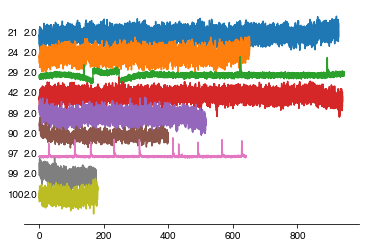

In [35]:
# Manual step: 
# Find the valid recordings 
plt.figure()
import seaborn as sns
mask = (frame['KCl']==2.0)*(frame['condition']!='BIC')

concs = na(frame['KCl'][mask])
traces = na(frame.F_detrended[mask])
times = na(frame.time[mask])
ids = na(frame['Culture ID'][mask])
print(frame.date[mask])
print(frame['Culture ID'][mask])
n_rec = 0
for i,trace in enumerate(traces):
    tr = trace
    t0=0
#     for n_rec,tr in enumerate(trace):#loop over two parts recordings
    ztrace=tr/np.max(tr)
    plt.plot(t0+times[i],ztrace-1.1*i)
    plt.text(-50,-1.1*i,concs[i])
    plt.text(-100,-1.1*i,ids[i])
    t0=np.max(times[i][n_rec])+100
plt.yticks([],[])
sns.despine(left=1)
ValidInd = {'-1':[1,27,30,38,43,44,45,46,47,57,67],#
           '-0.5':[8,11,12,15,19,25,31,33,40,52],
            '0.5':[3,4,9,13,14,28,36,37,53,55,62],#
            '1':[5,10,16,17,20,22,32,34,39,41,78,79,86,87],
            '2':[21,24,29,42]} 
# for c in ValidInd.keys():
#     pri
#     print(c,len(ValidInd[c]))


61    11-06-22
62    11-06-22
63    11-06-22
Name: date, dtype: object
61    21
62    21
63    21
Name: Culture ID, dtype: object


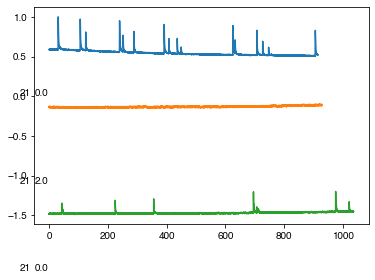

In [6]:
# Manual step: 
#Check if the culture bursted in return condition
plt.figure()
import seaborn as sns
idis = ValidInd['2'][0]
mask = frame['Culture ID']==idis
concs = na(frame['KCl'][mask])
traces = na(frame.F[mask])
times = na(frame.time[mask])
ids = na(frame['Culture ID'][mask])
print(frame.date[mask])
print(frame['Culture ID'][mask])
n_rec = 0
for i,trace in enumerate(traces):
    tr = trace
    t0=0
    ztrace=tr/np.max(tr)
    plt.plot(t0+times[i],ztrace-1.1*i)
    plt.text(-50,-1.1*i,concs[i])
    plt.text(-100,-1.1*i,ids[i])
    t0=np.max(times[i][n_rec])+100

# Detect bursts onsets 

## 1- Detect events with the highest possible sensitivity (lots of false positives)
* Remove polynomial tend
* Low-pass filter the signal
* z-score 
* detect blocks of points, where derivative is above threshold (value= 0.075),
* take only the first point where derivative is above the threshold
## 2 Find the burst end  = 10% decay of the maximum
* Take a window after the onset
* find a maximum 
* find 25th of the maximum to detend the burst duration
## 3- Estaimate the beseline noise from the timeseries between events 
## 4- Remove events that are blow noise threshold


In [179]:
def detect_burst_onset(time,trace,
                       min_iti=10,
                      derivative_threshold= 0.075):
    """Detect burst onset base on the derivative thresholding of the filtered trace
    

    Args:
        time (array): timestamp of the ca trace
        trace (array): ca trace
        min_iti (int, optional): min inter time interval for detecting the onset point
        derivative_threshold (float, optional): empirical threshold for the derivative

    Returns:
        onset_times (list): times of the burst onset
    """
    dt = np.diff(time)[0]
    T = np.max(time)         # Sample Period
    fs = 1/dt       # sample rate, Hz
    cutoff =1.     # desired cutoff frequency of the filter, Hz ,  
    n = int(T * fs) # total number of samples
    y = butter_lowpass_filter(trace,cutoff,fs,3) #filter high frequency noise
#     y = detrend(y, axis=0, type='linear', bp=0, overwrite_data=False) #remove linear trend
#     y= (y-np.mean(y))/np.std(y) #z-score
    dy = np.diff(y)
#     derivative_threshold = np.percentile(y,[95])
    onset_indices = np.where(dy>derivative_threshold)[0] #
    onset_times_raw = time[onset_indices]
    donset_times_raw = np.diff(onset_times_raw)
    break_off = True
    onset_times = []
    raise_length = 0
    raise_lengths = []
    
    
    for i,on_time in enumerate(onset_times_raw[:-1]):
        if ((onset_times_raw[i+1]-on_time)<min_iti) and break_off:
            onset_times.append(on_time)
#             print('t',len(onset_times))
            raise_lengths.append(raise_length)
            raise_length= 0
            break_off = False    
        elif ((onset_times_raw[i+1]-on_time)<min_iti):
            raise_length+=1            
        elif ((onset_times_raw[i+1]-on_time)>min_iti):
            break_off = True
#             print('l',len(raise_lengths))
    raise_lengths = raise_lengths[1:]  
    if len(onset_times)>len(raise_lengths):
        raise_lengths.append(raise_length)
    onset_times = na(onset_times)[na(raise_lengths)>2]#min raise length in samples of df
    return onset_times

def filteramp(time,trace,onset_times):
    """Filter bursts below 7std above the baseline and Extract burst features:
        1) amplitudes
        2) durations as decay to 25% of the max amp
    
    Args:
        time (array): timestamp of the ca trace
        trace (array): ca trace
        onset_times (list): times of the burst onset

    Returns:
        new_onset_times (list): filtered times of the burst onset\
        amps (list): burst amplitudes based on DFF signal
        amps_real (list): burst amplitudes of the original signal
        durations (list): burst durations
        
    """
    trace = trace-np.min(trace)
    dt= np.diff(time)[0]
    window = 5#5s window after the burst
    baseline_window = 1.#300ms pre burst baseline
    new_onset = []
    amps = []
    f0s = []
    amps_real = []
    durations= [ ]
    min_ibi = 1.#s
    max_dur= 20#s
    for i,on_time in enumerate(onset_times):
        #define window between two bursts
        if (i+1)>=len(onset_times):
            window = time[-1]
        else:
            window=onset_times[i+1]
        if (window-on_time)>min_ibi:
            mask = (time>on_time)*(time<window)#
            mask_pre = (time>(on_time-baseline_window))*(time<on_time)#
            #burst check
            f0= np.mean(trace[mask_pre])
            f0std = np.std(trace[mask_pre])
            burst = trace[mask]
            max_amp_real = np.max(burst)
#             print(i,f0+(7*f0std),max_amp_real)
            if max_amp_real>(f0+(3*f0std)):
                dff = (burst-f0)/f0
                max_amp = np.max(dff)
                # detect burst durations 
                arg_max_amp = np.argmax(dff)
                dur_ind = np.where(dff[arg_max_amp:]<(0.3*max_amp))[0]#0.5
                if len(dur_ind)>0:
#                     print(i,f0+(7*f0std),max_amp_real)
                    dur_ind = dur_ind[0]
                    #save the burst feature only if can detect duration
                    duration = (arg_max_amp+dur_ind+1)*dt
                    if duration<max_dur: #
                        durations.append(duration)
                        amps.append(max_amp)
                        amps_real.append(max_amp_real) 
                        new_onset.append(on_time) 
#                     plt.plot(dff)
                
                
    return new_onset,amps,amps_real,durations
            
#Burst duration 


        
        
        

## Plot activity of all cultures in one conditions

/home/ovinogradov/.local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/ovinogradov/.local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/ovinogradov/.local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/ovinogradov/.local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/ovinogradov/.local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: ele

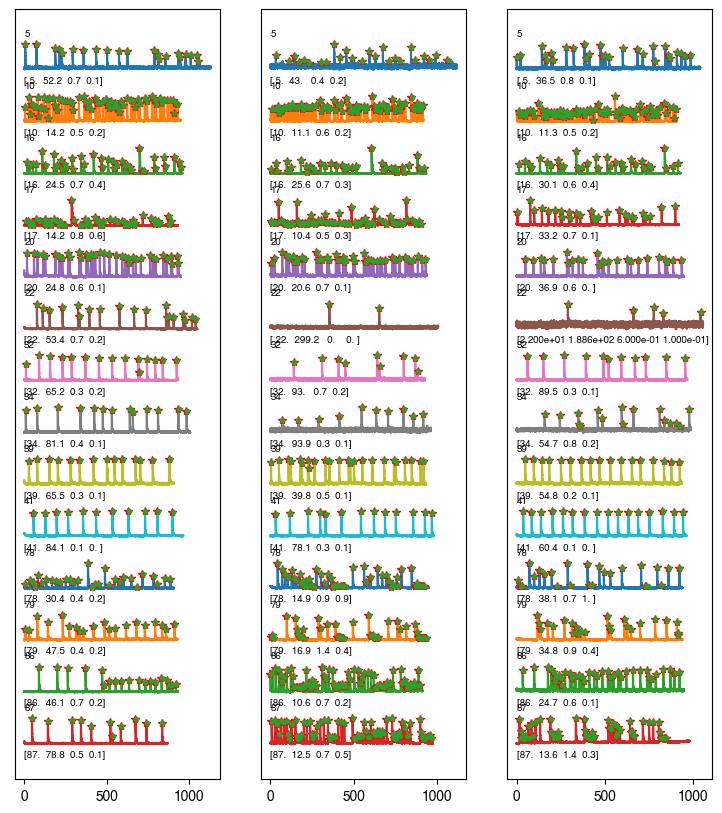

In [38]:
return_ids = list(ValidInd['1'])
plt.figure(figsize = (9,10))
sns.reset_orig()
summaries = np.zeros(shape=(len(return_ids),3,7))
for i,ind in enumerate(return_ids):
    mask = frame['Culture ID']==ind
    concs = na(frame['KCl'][mask])
    traces = na(frame.F[mask])
    times = na(frame.time[mask])
    for n in range(3):
        trace = traces[n].copy()
        time = times[n].copy()
        plt.subplot(1,3,n+1)
        trace = trace-np.mean(trace)
        mask1= trace< trace.mean()+np.std(trace)*2
        mask2=trace>trace.mean()-np.std(trace)*2
        model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
        predicted = np.polyval(model, time)
        detrended_trace = trace-predicted
        onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
        new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
        max_amp = np.max(amps_real)
        plt.plot(time,((detrended_trace-np.min(detrended_trace))/max_amp)-i*2,'-')
        plt.plot(new_onset,(amps_real/max_amp)-i*2,'*r')
        plt.plot(na(new_onset)+na(durations),(amps_real/max_amp)-i*2,'.C2')
        ibis = np.diff(new_onset)
        mibi = np.mean(ibis)
        cv = np.std(ibis)/mibi
        dur = np.mean(durations)
        mamp =np.mean(amps)
        cv_dur = np.std(durations)/dur
#         dur_corr=np.corrcoef(amps[1:],ibis)[0,1]
        dur_corr,p_v= corrcoef_s(durations[1:],ibis)
        plt.text(0,-i*2-0.5,np.round([ind,mibi,cv,cv_dur],1),fontsize=7)
#         plt.text(0,-i*2+1.3,concs[n],fontsize=7)
        plt.text(0,-i*2+1.3,ind,fontsize=7)

        summaries[i,n,:] = mibi,cv,dur,cv_dur,mamp,len(new_onset),dur_corr
    #     plt.xlim(0,2000)
        plt.yticks([],[])
# plt.tight_layout()




/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ovinogradov/.local/lib/python3.9/site-packages/numpy/core/fromnu

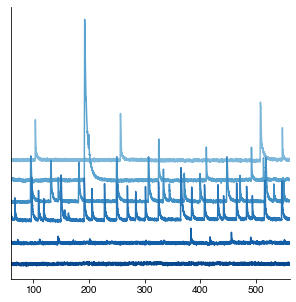

In [161]:

indis = [57,12,53,53,5,21]
concs_sel = [-1,-0.5,0,0.5,1,2]
plt.figure(figsize= (5,5))
colors= sns.color_palette('Blues',n_colors=5*2)[4:]

sns.reset_orig()
summaries = np.zeros(shape=(len(return_ids),3,7))
for i,ind in enumerate(indis):
    mask = frame['Culture ID']==ind
    concs = na(frame['KCl'][mask])
    n = 1#np.where([concs_sel[i] in concs])[0][0]
    if concs_sel[i]==0:
        n=0

    traces = na(frame.F[mask])
    times = na(frame.time[mask])

    trace = traces[n].copy()
    time = times[n].copy()
    
    trace = trace-np.mean(trace)
    mask1= trace< trace.mean()+np.std(trace)*2
    mask2=trace>trace.mean()-np.std(trace)*2
    model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
    predicted = np.polyval(model, time)
    detrended_trace = trace-predicted
    # onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
    # new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
    # max_amp = np.max(amps_real)
    plt.plot(time,((detrended_trace-np.min(detrended_trace))/max_amp)-i*1.2,'-',color=colors[i])
#     plt.plot(new_onset,(amps_real/max_amp)-i*2,'*r')
#     plt.plot(na(new_onset)+na(durations),(amps_real/max_amp)-i*2,'.C2')
    ibis = np.diff(new_onset)
    mibi = np.mean(ibis)
    cv = np.std(ibis)/mibi
    dur = np.mean(durations)
    mamp =np.mean(amps)
    cv_dur = np.std(durations)/dur
#         dur_corr=np.corrcoef(amps[1:],ibis)[0,1]
    dur_corr,p_v= corrcoef_s(durations[1:],ibis)
#     plt.text(0,-i*2-0.5,np.round([ind,mibi,cv,cv_dur],1),fontsize=7)
#         plt.text(0,-i*2+1.3,concs[n],fontsize=7)
#     plt.text(0,-i*2+1.3,ind,fontsize=7)

#     summaries[i,n,:] = mibi,cv,dur,cv_dur,mamp,len(new_onset),dur_corr
plt.xlim(60,560)
sns.despine()
plt.yticks([],[])
# plt.tight_layout()
plt.savefig('../../results/figs/paper_figs/perturbations/D3.pdf',fmt='pdf')




<IPython.core.display.Javascript object>


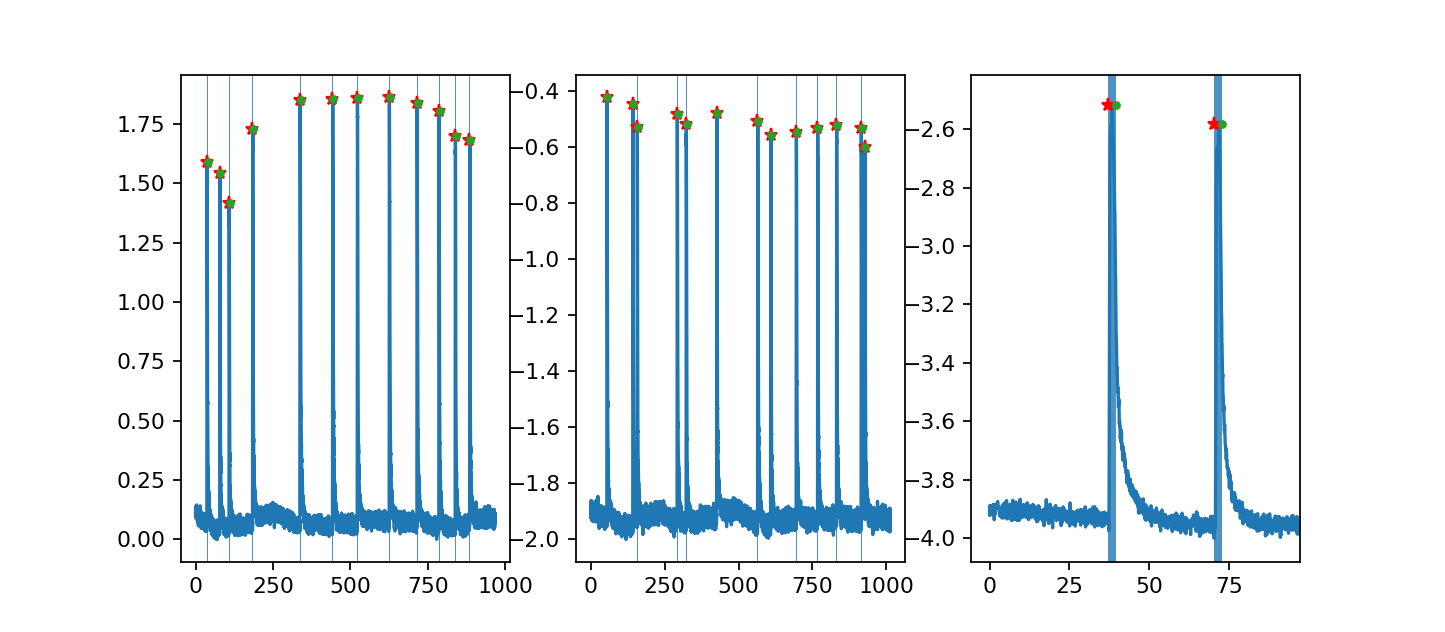

0 12
0.5 13
0-return 12


In [1779]:
summary_frame = pd.DataFrame(columns =['culture#','conc','summary_ca','summary_deconv','n_bursts','amp'])
# return_ids = np.hstack(list(ValidInd.values()))
return_ids =ValidInd['0.5']
mask = frame['Culture ID']==return_ids[6]
concs = na(frame['KCl'][mask])
traces = na(frame.F_detrended[mask])
times = na(frame.time[mask])
divs = na(frame.DIV[mask])
plt.figure(figsize=(7,3))
for i,trace in enumerate(traces):
    if len(traces)==3:
        time = times[i]
        trace = trace-np.mean(trace)
        # detrend
        mask1= trace< trace.mean()+np.std(trace)*2
        mask2=trace>trace.mean()-np.std(trace)*2
        model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
        predicted = np.polyval(model, time)
        detrended_trace = trace-predicted
        #get burst onsets and burst features
        onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
        new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
        plt.subplot(1,3,i+1)
        print(concs[i],len(new_onset))
        plt.plot(time,((detrended_trace-np.min(detrended_trace))/max_amp)-i*2,'-')
        plt.plot(new_onset,(amps_real/max_amp)-i*2,'*r')
        plt.plot(na(new_onset)+na(durations),(amps_real/max_amp)-i*2,'.C2')
        for k,new_on in enumerate(new_onset):
            plt.axvspan(new_on,new_on+durations[k],alpha=0.8)
        ibis = np.diff(new_onset)
        mibi = np.mean(ibis)
        cv = np.std(ibis)/mibi
        dur = np.mean(durations)
        mamp =np.mean(amps)
#         dur_corr=np.corrcoef(amps[1:],ibis)[0,1]
        dur_corr,_= corrcoef_s(amps[1:],ibis)



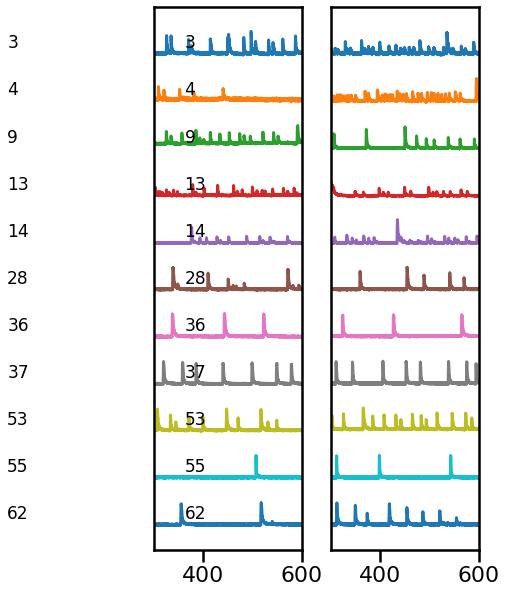

In [276]:
#Plot nice traces in seperate conditions 

nice_ind [0,0,3,0,0]

return_ids = list(ValidInd['0.5'])
plt.figure(figsize = (9,10))
summaries = np.zeros(shape=(len(return_ids),3,7))


for i,ind in enumerate(return_ids):
    mask = frame['Culture ID']==ind
    concs = na(frame['KCl'][mask])
    traces = na(frame.F[mask])
    times = na(frame.time[mask])
    for n in range(2):
        trace = traces[n].copy()
        time = times[n].copy()
        plt.subplot(1,3,n+1)
        trace = trace-np.mean(trace)
        mask1= trace< trace.mean()+np.std(trace)*2
        mask2=trace>trace.mean()-np.std(trace)*2
        model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
        predicted = np.polyval(model, time)
        detrended_trace = trace-predicted
        onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
        new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
        max_amp = np.max(amps_real)
        plt.plot(time,((detrended_trace-np.min(detrended_trace))/max_amp)-i*2,'-')
#         plt.plot(new_onset,(amps_real/max_amp)-i*2,'*r')
#         plt.plot(na(new_onset)+na(durations),(amps_real/max_amp)-i*2,'.C2')
#         ibis = np.diff(new_onset)
#         mibi = np.mean(ibis)
#         cv = np.std(ibis)/mibi
#         dur = np.mean(durations)
#         mamp =np.mean(amps)
#         cv_dur = np.std(durations)/dur
# #         dur_corr=np.corrcoef(amps[1:],ibis)[0,1]
#         dur_corr,p_v= corrcoef_s(durations[1:],ibis)
#         plt.text(0,-i*2-0.5,np.round([ind,mibi,cv,cv_dur],1),fontsize=7)
#         plt.text(0,-i*2+1.3,concs[n],fontsize=7)
        plt.text(2,-i*2+.3,ind,fontsize=17)
#         summaries[i,n,:] = mibi,cv,dur,cv_dur,mamp,len(new_onset),dur_corr
        plt.xlim(300,600)
        plt.yticks([],[])
# plt.tight_layout()




In [837]:
# Detect bursts 
na= np.array
def x_to_spikes(x,dt,scale = 10):
    """ convert continuous signal 
    to times of discrete events
    """
    x[x<0] = 0.
    spks = na(scale*(x/x.max()),dtype =int)
    st= np.where(spks)[0]
#     st_ = np.repeat(st,spks[st])
    return st*dt
def pre_select_bursts(time,trace,MI_params):
    dt = np.diff(time)[0]
    st = x_to_spikes(trace.copy(),dt=dt,scale=100)*1000
    bursts = MI_bursts(st,
          maxISIstart=MI_params['maxISIstart'],#70,#250,
          maxISIb=MI_params['maxISIb'],#70,#250,
          minBdur=MI_params['minBdur'],#100,
          minIBI=MI_params['minIBI'],#500,
          minSburst=MI_params['minSburst'])
    return bursts

MI_params_spikes = {'maxISIstart':300,
                 'maxISIb':300,
                 'minBdur':1,
                 'minIBI':300,
                 'minSburst':10.
                 }


<IPython.core.display.Javascript object>


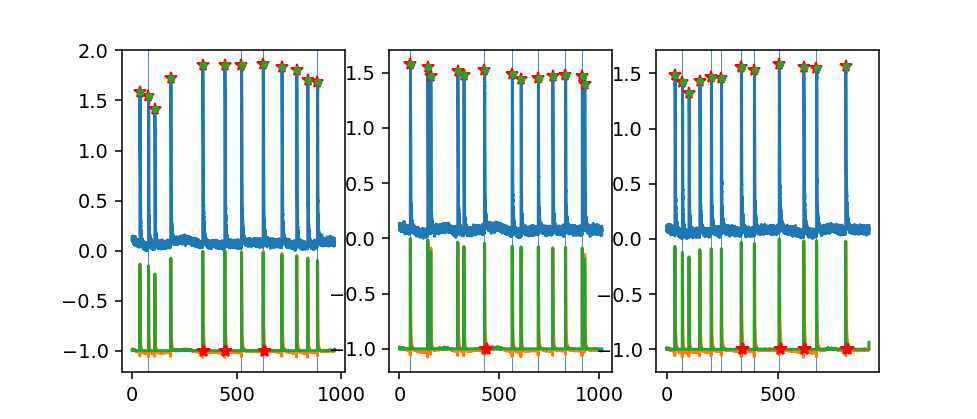

0 12
0.5 13
0-return 12


In [81]:
summary_frame = pd.DataFrame(columns =['culture#','conc','summary_ca','summary_deconv','n_bursts','amp'])
# return_ids = np.hstack(list(ValidInd.values()))
return_ids =ValidInd['0.5']
mask = frame['Culture ID']==return_ids[6]
concs = na(frame['KCl'][mask])
traces = na(frame.F_detrended[mask])
times = na(frame.time[mask])
divs = na(frame.DIV[mask])
plt.figure(figsize=(7,3))
for i,trace in enumerate(traces):
    if len(traces)==3:
        time = times[i]
        trace = trace-np.mean(trace)
        # detrend
        mask1= trace< trace.mean()+np.std(trace)*2
        mask2=trace>trace.mean()-np.std(trace)*2
        model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
        predicted = np.polyval(model, time)
        detrended_trace = trace-predicted
        #get burst onsets and burst features
        onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
        new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
        plt.subplot(1,3,i+1)
        print(concs[i],len(new_onset))
        plt.plot(time,((detrended_trace-np.min(detrended_trace))/max_amp),'-')
        plt.plot(new_onset,(amps_real/max_amp),'*r')
        plt.plot(na(new_onset)+na(durations),(amps_real/max_amp),'.C2')
        for k,new_on in enumerate(new_onset):
            plt.axvspan(new_on,new_on+durations[k],alpha=0.8)
        ibis = np.diff(new_onset)
        mibi = np.mean(ibis)
        cv = np.std(ibis)/mibi
        dur = np.mean(durations)
        mamp =np.mean(amps)
#         dur_corr=np.corrcoef(amps[1:],ibis)[0,1]
        dur_corr,_= corrcoef_s(amps[1:],ibis)
    
        dt = np.diff(time)[0]
        T = np.max(time)         # Sample Period
        fs = 1/dt       # sample rate, Hz
        cutoff =1.     # desired cutoff frequency of the filter, Hz ,  
        n = int(T * fs) # total number of samples
        y = butter_lowpass_filter(detrended_trace,cutoff,fs,3) #filter high frequency noise
        c, s, b, g, lam = deconvolve(y,penalty=2)#
        bursts2 = na(pre_select_bursts(time,s,MI_params_spikes))/1000
        plt.plot(time,y/np.max(y)-1)
        plt.plot(time,(s/np.max(s))-1)
        plt.plot(bursts2[:,0],np.ones(len(bursts2))*-1,'*')
        plt.plot(bursts2[:,1],np.ones(len(bursts2))*-1,'*r')

    



In [895]:

def filteramp(time,trace,onset_times):
    """Filter bursts below 7std above the baseline and Extract burst features:
        1) amplitudes
        2) durations as decay to 25% of the max amp
    
    Args:
        time (array): timestamp of the ca trace
        trace (array): ca trace
        onset_times (list): times of the burst onset

    Returns:
        new_onset_times (list): filtered times of the burst onset\
        amps (list): burst amplitudes based on DFF signal
        amps_real (list): burst amplitudes of the original signal
        durations (list): burst durations
        
    """
    trace = trace-np.min(trace)
    dt= np.diff(time)[0]
    window = 5#5s window after the burst
    baseline_window = 1.#300ms pre burst baseline
    new_onset = []
    amps = []
    f0s = []
    amps_real = []
    durations= [ ]
    min_ibi = 1.#s
    max_dur= 20#s
    for i,on_time in enumerate(onset_times):
        #define window between two bursts
        if (i+1)>=len(onset_times):
            window = time[-1]
        else:
            window=onset_times[i+1]
        if (window-on_time)>min_ibi:
            mask = (time>on_time)*(time<window)#
            mask_pre = (time>(on_time-baseline_window))*(time<on_time)#
            #burst check
            f0= np.mean(trace[mask_pre])
            f0std = np.std(trace[mask_pre])
            burst = trace[mask]
            max_amp_real = np.max(burst)
#             print(i,f0+(7*f0std),max_amp_real)
            if max_amp_real>(f0+(3*f0std)):
                dff = (burst-f0)/f0
                max_amp = np.max(dff)
                # detect burst durations 
                arg_max_amp = np.argmax(dff)
                dur_ind = np.where(dff[arg_max_amp:]<(0.25*max_amp))[0]#0.5
                if len(dur_ind)>0:
#                     print(i,f0+(7*f0std),max_amp_real)
                    dur_ind = dur_ind[0]
                    #save the burst feature only if can detect duration
                    duration = (arg_max_amp+dur_ind+1)*dt
                    if duration<max_dur: #
                        durations.append(duration)
                        amps.append(max_amp)
                        amps_real.append(max_amp_real) 
                        new_onset.append(on_time) 
#                     plt.plot(dff)
                
                
    return new_onset,amps,amps_real,durations
            

        
        
        

In [896]:
MI_params_spikes = {'maxISIstart':300,
                 'maxISIb':300,
                 'minBdur':1.,
                 'minIBI':300,
                 'minSburst':10.
                 }





summary_frame = pd.DataFrame(columns =['culture#','conc','summary_ca','summary_deconv','n_bursts','amp'])
return_ids = np.hstack(list(ValidInd.values()))
conc_dict ={
            '-1':1.,
            '-1.0':1.,
            '-1-return':1.,
            '-0.5':2.5,
            '0':4.,
            '0.0':4.,
            '0-return':4.,
            '0.5':5.5,
            '0.5-return':5.5,
            '1':7.,
            '1.0':7.,
            '1-return':7.,
            '2':10.,
            '2.0':10.
            }

# concs=[-1,-0.5,0,0.5,1,2,]#'0-return','0.5-return','-1-return','1-return']
# conc_real = [1,2.5,4,5.5,7,10,4.5,1.5,7.5]
labels=['mean IBI(s)','CV(IBI)','dur(s)','CV(dur)']
conds_labels = ['baseline','exp','return']
flag = 0
for culture_n in return_ids:
    mask = frame['Culture ID']==culture_n
    concs = na(frame['KCl'][mask])
    traces = na(frame.F_detrended[mask])
    times = na(frame.time[mask])
    divs = na(frame.DIV[mask])
    conds =na(frame['condition'][mask])
    flag = 0
    
    for i,trace in enumerate(traces):
        
        if flag==1:
            break
            
        if len(traces)==3:
            time = times[i]
            div = divs[i]
            trace = trace-np.mean(trace)
            # detrend
            mask1= trace< trace.mean()+np.std(trace)*2
            mask2=trace>trace.mean()-np.std(trace)*2
            model = np.polyfit(time[mask1*mask2],trace[mask1*mask2] , 4)
            predicted = np.polyval(model, time)
            detrended_trace = trace-predicted
            #get burst onsets and burst features
            onset_times = detect_burst_onset(time,detrended_trace,min_iti=1,derivative_threshold=.5)
            new_onset,amps,amps_real,durations = filteramp(time,detrended_trace,onset_times)
            burst_ends = na(new_onset)+na(durations)
            
            dt = np.diff(time)[0]
            T = np.max(time)         # Sample Period
            fs = 1/dt       # sample rate, Hz
            cutoff =1.     # desired cutoff frequency of the filter, Hz ,  
            n = int(T * fs) # total number of samples
            y = butter_lowpass_filter(detrended_trace,cutoff,fs,3) #filter high frequency noise
            # c, s, b, g, lam = deconvolve(y,penalty=0)#
            # bursts2 = na(pre_select_bursts(time,s,MI_params_spikes))/1000
            
            # print(culture_n,concs,len(new_onset))
            if len(new_onset)<2:
                flag = 1
                break
                
            else:
                # calculate average features
                
                ibis =new_onset[1:]-burst_ends[:-1]
                mibi = np.mean(ibis)
                cv = np.std(ibis)/mibi
                dur = np.mean(durations)
                mamp =np.mean(amps)
                cvdur = np.std(durations)/dur
                
#                 durs_dec = np.diff(bursts2)
#                 ibis_dec =(bursts2[1:,0]-bursts2[:-1,1])
                
#                 dur_dec = np.mean(durs_dec)
#                 mibi_dec = np.mean(ibis_dec)

#                 cv_dec = np.std(ibis_dec)/mibi_dec
#                 cvdur_dec = np.std(durs_dec)/dur_dec


    #                 dur_corr=np.corrcoef(durations[1:],ibis)[0,1]
                r1= np.corrcoef(ibis,durations[:-1])[0,1]
                r2= np.corrcoef(ibis,durations[1:])[0,1]
                # if not 'return' in str(conds[i]):
                    
                frame_ = pd.DataFrame({'culture#':culture_n,
                                       'trace':[detrended_trace],
                                       'time':[time],
                                       'div':div,
                                       'conc':concs[i],
                                       'kcl':conc_dict[str(concs[i])],
                                       'mibi':mibi,
                                       'cv':cv,
                                       'dur':dur,
                                       'amp':mamp,
                                       'cvdur':cvdur,
                                       # 'd_mibi':mibi_dec,
                                       # 'd_cv':cv_dec,
                                       # 'd_dur':dur_dec,
                                       'summary_ca':[[mibi,cv,dur,cvdur]],
                                       'n_bursts':len(new_onset),'amp':mamp,'r1':r1,'r2':r2,
                                        'condition':conds[i],
                                       'i':conds_labels[i],
                                       'experimental_group':conc_dict[str(concs[1])]
                                      })

                summary_frame=  summary_frame.append(frame_,ignore_index=1)

<ipython-input-896-a240fb46d877>:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_frame=  summary_frame.append(frame_,ignore_index=1)
<ipython-input-896-a240fb46d877>:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_frame=  summary_frame.append(frame_,ignore_index=1)
<ipython-input-896-a240fb46d877>:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_frame=  summary_frame.append(frame_,ignore_index=1)
<ipython-input-896-a240fb46d877>:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_frame=  summary_frame.append(frame_,ignore_index=1)
<ipython-input-896-a240fb46d877>:130: FutureWarning: The frame.appen

In [900]:
summary_frame.to_pickle('../../data/kcl_summary_full5')

In [897]:
def get_slope(mibi,dur,j):
    p_up= dur/(mibi+dur)
    mean_x = p_up *j #+  p_down*0.0001 
    return mean_x


In [808]:
summary_frame['slope']= get_slope(summary_frame['mibi'],summary_frame['dur'],9)
invalid_numbers = na(summary_frame[summary_frame['n_bursts']<3]['culture#'])
s =summary_frame[~np.isin(na(summary_frame['culture#']), invalid_numbers)]

<AxesSubplot:xlabel='kcl', ylabel='slope'>

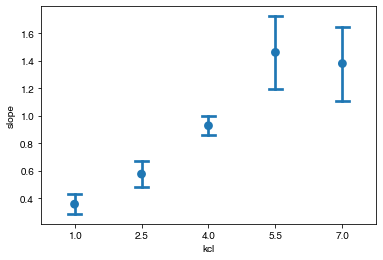

In [811]:
sns.pointplot(x='kcl',y='slope',data=s[(s['condition']!='return')*(s['kcl']<10)],errorbar='se',join=False,capsize=.2)

In [ ]:

### Statistical tests

In [775]:
data = s[(s['condition']!='return')]
g1 = data[data['kcl']==4.]
pvals = []
for kcl in [1.,2.5,5.5,7.]:
    g2 = data[data['kcl']==kcl]
    s_,p = ttest_ind(na(g1[summary]),na(g2[summary]),permutations=10000)
    pvals.append(p)
from statsmodels.stats.multitest import multipletests
multipletests(pvals, alpha=0.05, method='fdr_bh')
    

In [25]:
summary_frame.to_pickle('../../data/kcl_summary_full2')
